# 1. data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

In [2]:
# there are some ", and \n" inside some examples so we need to handle that when reading csv
import csv

input_file = '../dataset/train.csv'
output_file = '../dataset/train_fixed.csv'

with open(input_file, 'r', encoding='utf-8', newline='') as infile, \
     open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    
    reader = csv.reader(infile)
    # this line means if face some special charater mentioned above, it will quote them as a whole part
    writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
    
    headers = next(reader)
    writer.writerow(headers)

    for row in reader:
        if len(row) >= 3:
            img_id, labels = row[0], row[1]
            caption_parts = row[2:]

            caption_parts = [part.replace('\n', '').replace('\r', '').strip()
                             for part in caption_parts if part.strip() != '']

            caption = ', '.join(caption_parts).rstrip(',')

            writer.writerow([img_id, labels, caption])
        else:
            print(f"still have some issues inside rows (test)：{row}")
            
print(f"finished! new document file path:{output_file}")

finished! new document file path:../dataset/train_fixed.csv


In [3]:
# there some ", and \n" inside some examples so we need to handle that when reading csv
import csv

input_file = '../dataset/test.csv'
output_file = '../dataset/test_fixed.csv'

with open(input_file, 'r', encoding='utf-8', newline='') as infile, \
     open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    
    reader = csv.reader(infile)
    # this line means if face some special charater mentioned above, it will quote them as a whole part
    writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
    
    headers = next(reader)
    writer.writerow(headers)

    for row in reader:
        if len(row) >= 2:
            img_id = row[0]
            caption_parts = row[1:]

            caption_parts = [part.replace('\n', '').replace('\r', '').strip()
                             for part in caption_parts if part.strip() != '']

            caption = ', '.join(caption_parts).rstrip(',')

            writer.writerow([img_id, caption])
        else:
            print(f"still have some issues inside rows (test)：{row}")
            
print(f"finished! new document file path:{output_file}")

finished! new document file path:../dataset/test_fixed.csv


In [4]:
train_df = pd.read_csv('../dataset/train_fixed.csv')
test_df = pd.read_csv('../dataset/test_fixed.csv')

In [5]:
# some caption ends with "," so wrongly generate a new column
train_df.drop(columns=['Unnamed: 3'], inplace=True)
train_df.to_csv('../dataset/train_fixed.csv', index=False, encoding='utf-8')

In [6]:
train_df.head(5)

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


In [ ]:
# train_fixed.csv padding

In [ ]:
# train datasets use padding
import pandas as pd
import os
from PIL import Image

train_csv_file = '../dataset/train_fixed.csv'
df_train = pd.read_csv(train_csv_file)

original_img_dir = '../dataset/images'

processed_img_dir = '../dataset/processed_images'
os.makedirs(processed_img_dir, exist_ok=True)

# found that the size of imgs within 320 x 320
target_size = (320, 320)

def pad_to_320(img, target_size=(320,320)):
    original_width, original_height = img.size
    target_width, target_height = target_size
    
    new_img = Image.new("RGB", target_size, (0, 0, 0))

    left = (target_width - original_width) // 2
    top = (target_height - original_height) // 2
    new_img.paste(img, (left, top))

    return new_img

for idx, row in df_test.iterrows():
    img_id = row['ImageID']
    original_img_path = os.path.join(original_img_dir, img_id)
    processed_img_path = os.path.join(processed_img_dir, img_id)

    try:
        img = Image.open(original_img_path).convert('RGB')
    except Exception as e:
        print(f"cannot load the img {img_id}: {e}")
        continue

    processed_img = pad_to_320(img, target_size)

    processed_img.save(processed_img_path)

print("training imgs save to'../dataset/processed_images'")


In [ ]:
# test datasets
import pandas as pd
import os
from PIL import Image

test_csv_file = '../dataset/test_fixed.csv'
df_test = pd.read_csv(test_csv_file)

original_img_dir = '../dataset/images'

processed_img_dir = '../dataset/processed_images'
os.makedirs(processed_img_dir, exist_ok=True)

target_size = (320, 320)

def pad_to_320(img, target_size=(320,320)):
    original_width, original_height = img.size
    target_width, target_height = target_size
    
    new_img = Image.new("RGB", target_size, (0, 0, 0))

    left = (target_width - original_width) // 2
    top = (target_height - original_height) // 2
    new_img.paste(img, (left, top))

    return new_img

for idx, row in df_test.iterrows():
    img_id = row['ImageID']
    original_img_path = os.path.join(original_img_dir, img_id)
    processed_img_path = os.path.join(processed_img_dir, img_id)

    try:
        img = Image.open(original_img_path).convert('RGB')
    except Exception as e:
        print(f"can not load the img {img_id}: {e}")
        continue

    processed_img = pad_to_320(img, target_size)

    processed_img.save(processed_img_path)

print("testing imgs save to'../dataset/processed_images'")

# 2. handle imgs and labels

# 2.1 data augmentation

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from collections import defaultdict
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomResizedCrop

# the classes distribution is uneven, so try to do data augmentation to balance the class
augmentation_transform = Compose([
    RandomHorizontalFlip(),
    RandomRotation(30),
    ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    RandomResizedCrop(size=(320,320), scale=(0.7, 1.0)),
])

df = pd.read_csv('../dataset/train_fixed.csv')
df['Labels_set'] = df['Labels'].apply(lambda x: set(int(i) for i in str(x).split()))

class_to_indices = defaultdict(set)
for idx, labels in enumerate(df['Labels_set']):
    for label in labels:
        class_to_indices[label].add(idx)

# target number for each class
target_counts = {
    2: 3000, 4: 3000, 5: 3000, 6: 3000, 7: 3000, 
    8: 3000, 9: 3000, 10: 3000, 11: 3000, 13: 3000, 
    14: 2500, 15: 3000, 16: 3000, 17: 3000, 18: 3000, 19: 3000
}

global_aug_counter = 0
generated_augmented_images = set()
new_records = []

augmented_img_dir = '../dataset/processed_images_augmented'
os.makedirs(augmented_img_dir, exist_ok=True)

# keep all the data
selected_indices = set(range(len(df)))

for class_id, target in target_counts.items():
    current_indices = class_to_indices[class_id]
    current_count = len(current_indices)
    
    augment_needed = target - current_count
    if augment_needed <= 0:
        continue
    
    current_indices_list = list(current_indices)
    
    for _ in range(augment_needed):
        idx_to_augment = np.random.choice(current_indices_list)
        row = df.iloc[idx_to_augment]
        img_id = row['ImageID']
        labels = row['Labels']

        img_path = os.path.join('../dataset/processed_images', img_id)
        image = Image.open(img_path).convert('RGB')
        augmented_image = augmentation_transform(image)

        new_img_id = f'aug_{global_aug_counter}_{img_id}'
        global_aug_counter += 1

        while new_img_id in generated_augmented_images:
            new_img_id = f'aug_{global_aug_counter}_{img_id}'
            global_aug_counter += 1

        augmented_img_path = os.path.join(augmented_img_dir, new_img_id)
        augmented_image.save(augmented_img_path)
        generated_augmented_images.add(new_img_id)

        new_records.append({'ImageID': new_img_id, 'Labels': labels})

df_original = df[['ImageID', 'Labels']]
df_augmented = pd.DataFrame(new_records).drop_duplicates(subset=['ImageID'])

df_final = pd.concat([df_original, df_augmented], ignore_index=True)

df_final.to_csv('../dataset/train_augmented_full.csv', index=False)
print("finish data augmentation，save in 'train_augmented_full.csv'")

# 2.2 split the datasets

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split

csv_file = '../dataset/train_augmented_full.csv'
df = pd.read_csv(csv_file)

# 90%train，10%validation
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_df.to_csv('../dataset/train_split.csv', index=False)
val_df.to_csv('../dataset/val_split.csv', index=False)

print(f"train_split: {len(train_df)}")
print(f"validation_split: {len(val_df)}")

train_split: 52311
validation_split: 5813


In [35]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
from torchvision.transforms import Compose, ToTensor

class ImageDataset(Dataset):
    def __init__(self, df, original_img_dir, augmented_img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.original_img_dir = original_img_dir
        self.augmented_img_dir = augmented_img_dir
        self.transform = transform
        self.num_classes = 18

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['ImageID']
        
        if img_id.startswith('aug_'):
            img_path = os.path.join(self.augmented_img_dir, img_id)
        else:
            img_path = os.path.join(self.original_img_dir, img_id)
        
        image = Image.open(img_path).convert('RGB')
    
        if self.transform:
            image = self.transform(image)
    
        # One-hot remove the class 12
        label_vec = torch.zeros(self.num_classes, dtype=torch.float32)
        labels_str = str(row['Labels']).split()
        for label in labels_str:
            label_idx = int(label) - 1
            # Classes 1-11
            if label_idx < 11:          
                label_vec[label_idx] = 1.0
            # Classes 13-19
            elif label_idx > 11:        
                label_vec[label_idx - 1] = 1.0
        return image, label_vec, img_id

In [36]:
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor

train_df = pd.read_csv('../dataset/train_split.csv')
val_df = pd.read_csv('../dataset/val_split.csv')
test_df = pd.read_csv('../dataset/test_fixed.csv')
transform = Compose([ToTensor()])

train_dataset = ImageDataset(train_df, '../dataset/processed_images', '../dataset/processed_images_augmented', transform)
val_dataset = ImageDataset(val_df, '../dataset/processed_images', '../dataset/processed_images_augmented', transform)
test_dataset = ImageDataset(test_df, '../dataset/processed_images', transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

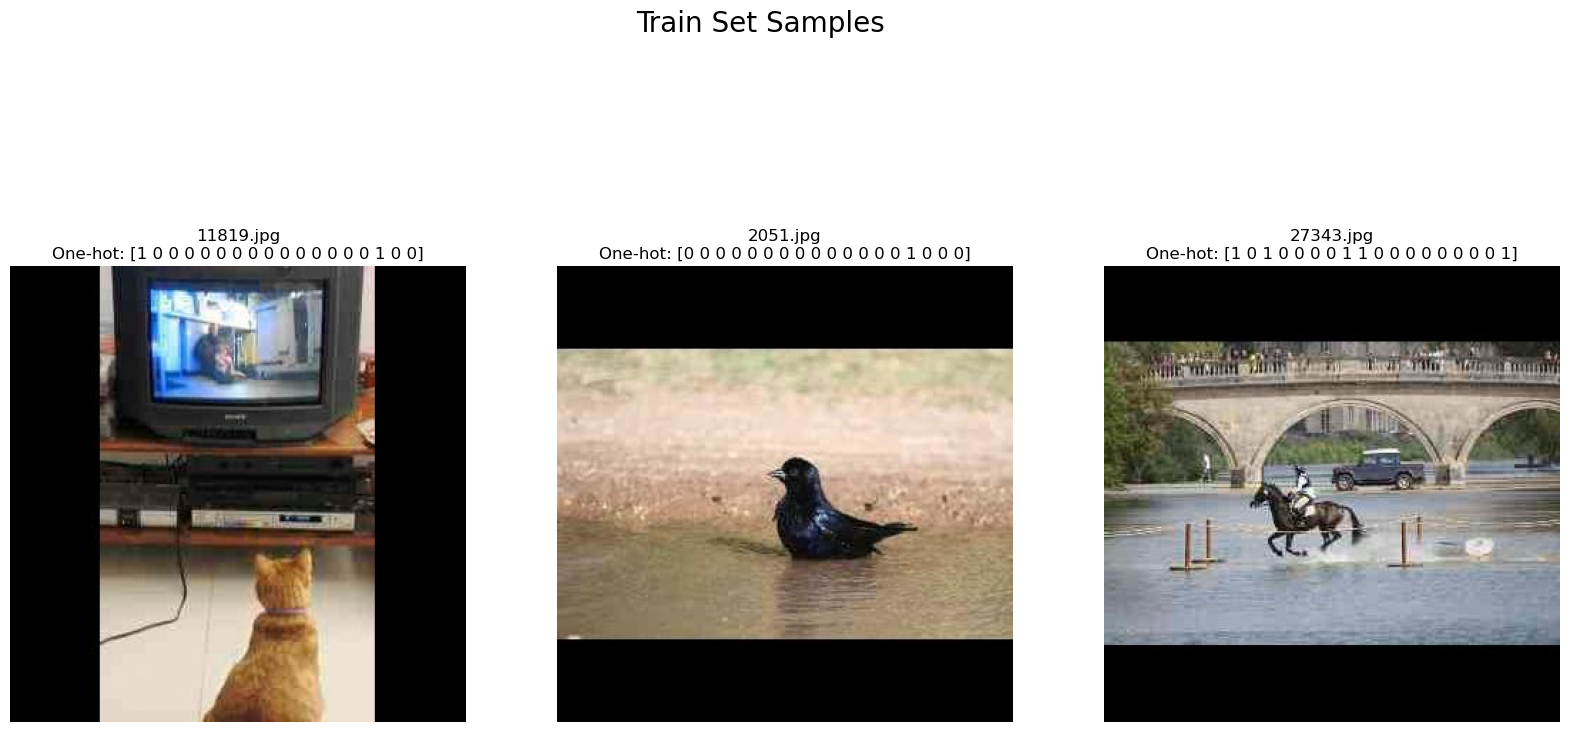

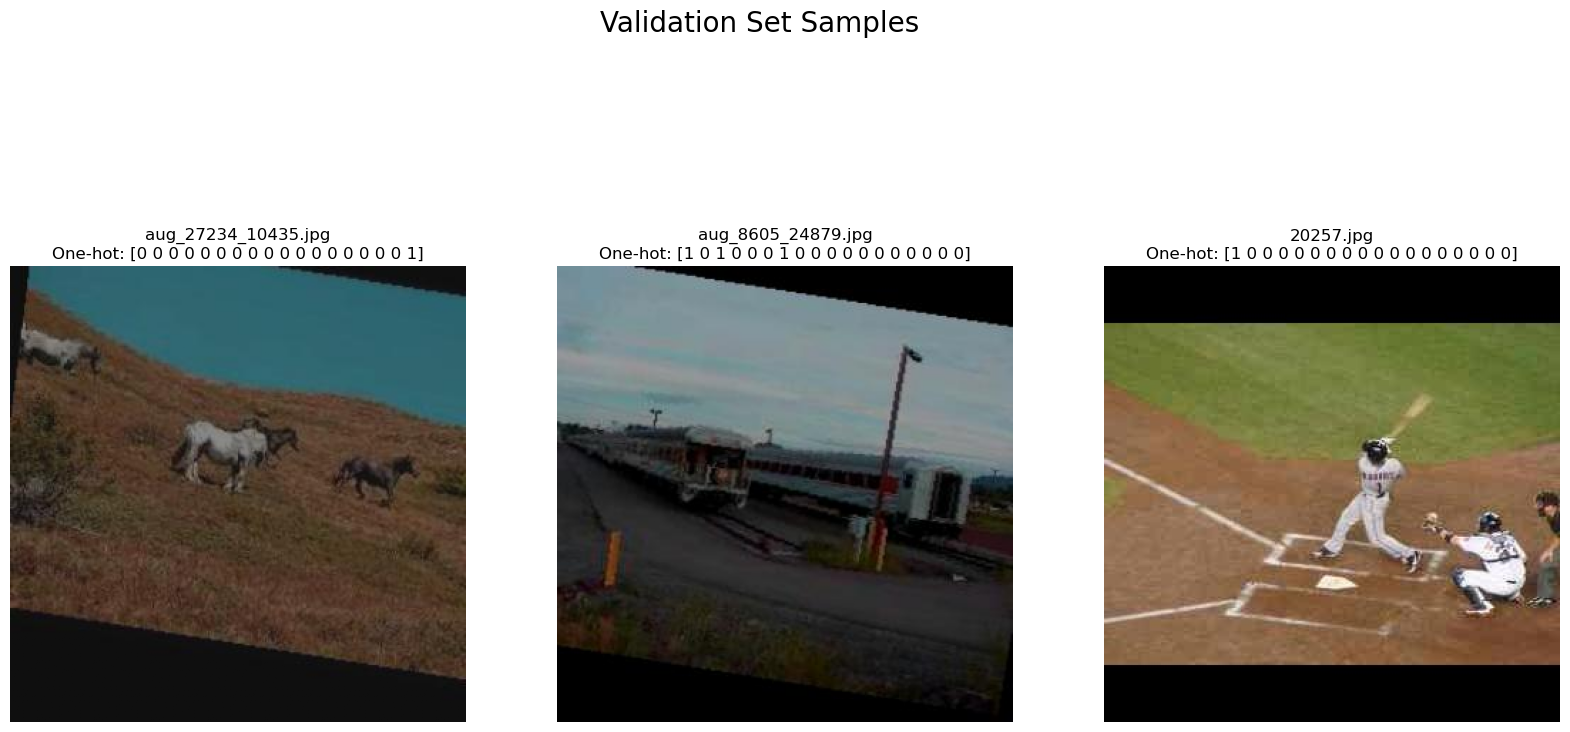

In [37]:
import matplotlib.pyplot as plt

def show_samples(loader, title):
    images, labels, img_ids = next(iter(loader))

    plt.figure(figsize=(20, 10))
    for idx in range(min(3, len(images))):
        image = images[idx].permute(1, 2, 0).numpy()
        label = labels[idx].numpy().astype(int)
        img_id = img_ids[idx]

        plt.subplot(1, 3, idx + 1)
        plt.imshow(image)
        plt.title(f"{img_id}\nOne-hot: {label}")
        plt.axis('off')

    plt.suptitle(title, fontsize=20)
    plt.show()

show_samples(train_loader, "Train Set Samples")
show_samples(val_loader, "Validation Set Samples")

In [22]:
train_df.head()

,ImageID,Labels
0,aug_8054_7251.jpg,16 1
1,aug_9120_6188.jpg,19
2,25590.jpg,13
3,18949.jpg,1
4,aug_8193_28211.jpg,16 1


In [21]:
train_df[train_df['ImageID'] == 'aug_3127_16663.jpg']
# note that there are slightly different in the position, because there isn't class 12, so the original index of class 12 becomes class 13

,ImageID,Labels
3926,aug_3127_16663.jpg,1 3 7


# 3. CNN

In [39]:
import torch
import torch.nn as nn

# Basic convolutional block: Conv2d -> BatchNorm -> ReLU
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, 
                               padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Inception-ResNet-A module (37x37 grid in original Inception-ResNet-v1)
class InceptionResNetA(nn.Module):
    def __init__(self, in_channels):
        super(InceptionResNetA, self).__init__()
        # Branch 0: 1x1 conv
        self.branch0 = BasicConv2d(in_channels, 32, kernel_size=1)
        # Branch 1: 1x1 conv -> 3x3 conv
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=1),
            BasicConv2d(32, 32, kernel_size=3, padding=1)
        )
        # Branch 2: 1x1 conv -> 3x3 conv -> 3x3 conv
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=1),
            BasicConv2d(32, 32, kernel_size=3, padding=1),
            BasicConv2d(32, 32, kernel_size=3, padding=1)
        )
        # Concatenate branches outputs (channels: 32+32+32 = 96), then linear 1x1 conv to match in_channels
        self.concat_conv = nn.Conv2d(96, in_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        out0 = self.branch0(x)
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        # Concatenate outputs of all branches along channel dimension
        out = torch.cat([out0, out1, out2], dim=1)
        # Linear combination to reduce channels back to in_channels
        out = self.concat_conv(out)
        # Residual add & ReLU
        out = self.relu(out + x)
        return out

# Inception-ResNet-B module (18x18 grid in original network)
class InceptionResNetB(nn.Module):
    def __init__(self, in_channels):
        super(InceptionResNetB, self).__init__()
        # Branch 0: 1x1 conv
        self.branch0 = BasicConv2d(in_channels, 128, kernel_size=1)
        # Branch 1: 1x1 conv -> 1x7 conv -> 7x1 conv, use factorization for conv
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channels, 128, kernel_size=1),
            BasicConv2d(128, 128, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(128, 128, kernel_size=(7, 1), padding=(3, 0))
        )
        # Concatenate (128+128=256 channels), then linear conv back to in_channels
        self.concat_conv = nn.Conv2d(256, in_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        out0 = self.branch0(x)
        out1 = self.branch1(x)
        out = torch.cat([out0, out1], dim=1)
        out = self.concat_conv(out)
        out = self.relu(out + x)  # residual connection
        return out

# Inception-ResNet-C module (8x8 grid in original network)
class InceptionResNetC(nn.Module):
    def __init__(self, in_channels):
        super(InceptionResNetC, self).__init__()
        # Branch 0: 1x1 conv
        self.branch0 = BasicConv2d(in_channels, 192, kernel_size=1)
        # Branch 1: 1x1 conv -> 1x3 conv -> 3x1 conv
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(192, 192, kernel_size=(3, 1), padding=(1, 0))
        )
        # Concatenate (192+192=384), linear conv to in_channels
        self.concat_conv = nn.Conv2d(384, in_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        out0 = self.branch0(x)
        out1 = self.branch1(x)
        out = torch.cat([out0, out1], dim=1)
        out = self.concat_conv(out)
        out = self.relu(out + x)  # residual add
        return out

# Reduction-A block: reduces spatial size (37x37 -> 18x18) and increases channels
class ReductionA(nn.Module):
    def __init__(self, in_channels):
        super(ReductionA, self).__init__()
        # Branch 0: 3x3 conv stride 2
        self.branch0 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)
        # Branch 1: 1x1 conv -> 3x3 conv -> 3x3 conv (stride 2)
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=3, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )
        # Branch 2: 3x3 max pool stride 2
        self.branch2 = nn.MaxPool2d(kernel_size=3, stride=2)
    def forward(self, x):
        out0 = self.branch0(x)
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        # Concatenate along channels (output channels: 384+256+in_channels)
        out = torch.cat([out0, out1, out2], dim=1)
        return out

# Reduction-B block: reduces spatial size (17x17 -> 8x8), increases channels
class ReductionB(nn.Module):
    def __init__(self, in_channels):
        super(ReductionB, self).__init__()
        # Branch 0: 1x1 conv -> 3x3 conv (stride 2)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )
        # Branch 1: 1x1 conv -> 3x3 conv (stride 2)
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )
        # Branch 2: 1x1 conv -> 3x3 conv -> 3x3 conv (stride 2)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1),
            BasicConv2d(256, 256, kernel_size=3, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )
        # Branch 3: 3x3 max pool stride 2
        self.branch3 = nn.MaxPool2d(kernel_size=3, stride=2)
    def forward(self, x):
        out0 = self.branch0(x)
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        # Concatenate outputs of all branches
        out = torch.cat([out0, out1, out2, out3], dim=1)
        return out

# Complete Inception-ResNet-v1 model for multi-label classification
class InceptionResNetV1_MultiLabel(nn.Module):
    def __init__(self, num_classes=18, dropout_prob=0.5):
        super(InceptionResNetV1_MultiLabel, self).__init__()
        # Stem convolutional layers (output feature map size: 79x79 with 256 channels)
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)      # 320 -> 159
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)     # 159 -> 157 
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 157 -> 157
        self.maxpool_3a = nn.MaxPool2d(kernel_size=3, stride=2)           # 157 -> 78
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)     # 78 -> 78
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)    # 78 -> 76
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)   # 76 -> 38
        # Inception-ResNet-A modules (×5)
        self.irA1 = InceptionResNetA(256)
        self.irA2 = InceptionResNetA(256)
        self.irA3 = InceptionResNetA(256)
        self.irA4 = InceptionResNetA(256)
        self.irA5 = InceptionResNetA(256)
        # Reduction-A to go from 37×37 -> 18×18 (channels: 256 -> 896)
        self.reduction_A = ReductionA(256)
        # Inception-ResNet-B modules (×10)
        self.irB1 = InceptionResNetB(896)
        self.irB2 = InceptionResNetB(896)
        self.irB3 = InceptionResNetB(896)
        self.irB4 = InceptionResNetB(896)
        self.irB5 = InceptionResNetB(896)
        self.irB6 = InceptionResNetB(896)
        self.irB7 = InceptionResNetB(896)
        self.irB8 = InceptionResNetB(896)
        self.irB9 = InceptionResNetB(896)
        self.irB10 = InceptionResNetB(896)
        # Reduction-B to go from 18×18 -> 8×8 (channels: 896 -> 1792)
        self.reduction_B = ReductionB(896)
        # Inception-ResNet-C modules (×5)
        self.irC1 = InceptionResNetC(1792)
        self.irC2 = InceptionResNetC(1792)
        self.irC3 = InceptionResNetC(1792)
        self.irC4 = InceptionResNetC(1792)
        self.irC5 = InceptionResNetC(1792)
        # Output head: global average pool -> dropout -> linear -> sigmoid
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(1792, num_classes)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # Stem
        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        # Inception-ResNet-A, 5 blocks inside
        x = self.irA1(x)
        x = self.irA2(x)
        x = self.irA3(x)
        x = self.irA4(x)
        x = self.irA5(x)
        # Reduction-A
        x = self.reduction_A(x)
        # Inception-ResNet-B, 10 blocks inside
        x = self.irB1(x)
        x = self.irB2(x)
        x = self.irB3(x)
        x = self.irB4(x)
        x = self.irB5(x)
        x = self.irB6(x)
        x = self.irB7(x)
        x = self.irB8(x)
        x = self.irB9(x)
        x = self.irB10(x)
        # Reduction-B
        x = self.reduction_B(x)
        # Inception-ResNet-C 5 blocks inside
        x = self.irC1(x)
        x = self.irC2(x)
        x = self.irC3(x)
        x = self.irC4(x)
        x = self.irC5(x)
        # Global average pooling, dropout, and fully-connected
        x = self.avg_pool(x)               # shape: (batch, 1792, 1, 1)
        x = x.view(x.size(0), -1)          # flatten to (batch, 1792)
        x = self.dropout(x)
        logits = self.fc(x)                # linear output (batch, 18)
        probs = self.sigmoid(logits)       # apply sigmoid to get probabilities in [0,1], cuz this is multi-label classification
        return probs

In [42]:
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch
from sklearn.metrics import f1_score

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Initialize model, loss function, optimizer
model = InceptionResNetV1_MultiLabel(num_classes=18, dropout_prob=0.5).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30
best_val_loss = float('inf')

# define how to calculate micro-F1
def calculate_micro_f1(outputs, labels, threshold=0.5):
    outputs = outputs.detach().cpu().numpy() >= threshold
    labels = labels.detach().cpu().numpy()
    return f1_score(labels, outputs, average='micro', zero_division=0)

# if this metric looks better then save the model
best_val_loss = float('inf')
best_val_f1 = 0.0 

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    # Training loop
    for images, labels, _ in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        all_train_preds.append(outputs.detach().cpu())
        all_train_labels.append(labels.detach().cpu())

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_preds = torch.cat(all_train_preds, dim=0)
    train_labels = torch.cat(all_train_labels, dim=0)
    train_micro_f1 = calculate_micro_f1(train_preds, train_labels)

    # Validation loop
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for images, labels, _ in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            all_val_preds.append(outputs.cpu())
            all_val_labels.append(labels.cpu())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_preds = torch.cat(all_val_preds, dim=0)
    val_labels = torch.cat(all_val_labels, dim=0)
    val_micro_f1 = calculate_micro_f1(val_preds, val_labels)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {avg_train_loss:.4f}, Train Micro-F1: {train_micro_f1:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Micro-F1: {val_micro_f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model_loss.pth")
        print(f"Saved best loss model at epoch {epoch} (val loss {best_val_loss:.4f})")

    if val_micro_f1 > best_val_f1:
        best_val_f1 = val_micro_f1
        torch.save(model.state_dict(), "best_model_f1.pth")
        print(f"Saved best F1 model at epoch {epoch} (val micro-f1 {best_val_f1:.4f})")

Using device: cuda
Epoch 1/30 — Train Loss: 0.2776, Train Micro-F1: 0.4185 | Val Loss: 0.2665, Val Micro-F1: 0.4259
Saved best loss model at epoch 1 (val loss 0.2665)
Saved best F1 model at epoch 1 (val micro-f1 0.4259)
Epoch 2/30 — Train Loss: 0.2487, Train Micro-F1: 0.4363 | Val Loss: 0.2436, Val Micro-F1: 0.4497
Saved best loss model at epoch 2 (val loss 0.2436)
Saved best F1 model at epoch 2 (val micro-f1 0.4497)
Epoch 3/30 — Train Loss: 0.2340, Train Micro-F1: 0.4711 | Val Loss: 0.2330, Val Micro-F1: 0.4699
Saved best loss model at epoch 3 (val loss 0.2330)
Saved best F1 model at epoch 3 (val micro-f1 0.4699)
Epoch 4/30 — Train Loss: 0.2217, Train Micro-F1: 0.5061 | Val Loss: 0.2245, Val Micro-F1: 0.5165
Saved best loss model at epoch 4 (val loss 0.2245)
Saved best F1 model at epoch 4 (val micro-f1 0.5165)
Epoch 5/30 — Train Loss: 0.2090, Train Micro-F1: 0.5387 | Val Loss: 0.2094, Val Micro-F1: 0.5352
Saved best loss model at epoch 5 (val loss 0.2094)
Saved best F1 model at epoch 

KeyboardInterrupt: 

In [38]:
# see the distribution of datasets
def count_labels_fast(loader, num_classes=18):
    label_counts = torch.zeros(num_classes, dtype=torch.int32)
    
    for _, labels, _ in loader:
        label_counts += labels.sum(dim=0).int()
    
    return label_counts.numpy()

train_label_counts = count_labels_fast(train_loader)
print("distribution of training labels:", train_label_counts)

val_label_counts = count_labels_fast(val_loader)
print("distribution of validation labels:", val_label_counts)

distribution of training labels: [33861  4175 11684  3612  2904  3977  3180  5683  3079  4599  3209  3169
  2433  3771  3040  2932  3313  2976]
distribution of validation labels: [3774  478 1338  418  323  467  321  660  384  485  375  354  274  399
  359  326  388  345]


In [47]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import os
from torchvision.transforms import Compose, ToTensor
from PIL import Image

model = InceptionResNetV1_MultiLabel(num_classes=18, dropout_prob=0.5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.load_state_dict(torch.load("best_model_f1.pth"))
model.eval()

predictions = []

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, img_ids in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        preds_binary = (outputs.cpu().numpy() >= 0.5).astype(int)

        all_preds.append(preds_binary)
        all_labels.append(labels.cpu().numpy())

        for img_id, pred in zip(img_ids, preds_binary):
            label_indices = np.where(pred == 1)[0]

            label_strs = []
            for idx in label_indices:
                if idx < 11:
                    label_strs.append(str(idx + 1))
                else:
                    label_strs.append(str(idx + 2))  

            predictions.append({
                'ImageID': img_id,
                'Labels': ' '.join(label_strs)
            })

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

micro_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
print(f"print f1 on datasets: {micro_f1:.4f}")

result_df = pd.DataFrame(predictions)
result_csv_path = 'test_predictions.csv'
result_df.to_csv(result_csv_path, index=False)

print(f"save predict datasets '{result_csv_path}'")

print(result_df.head(10))

print f1 on datasets: 0.0000
save predict datasets 'test_predictions.csv'
     ImageID   Labels
0  30000.jpg        1
1  30001.jpg  1 2 3 6
2  30002.jpg        1
3  30003.jpg        1
4  30004.jpg      1 4
5  30005.jpg        1
6  30006.jpg       16
7  30007.jpg      1 9
8  30008.jpg       16
9  30009.jpg        1


In [ ]:
'''
this module means to see the predict digits of CNN, 
so that i can judge that the threshold = 0.5 is good or not for performance


import numpy as np
import torch
import pandas as pd

# Load the best model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResNetV1_MultiLabel(num_classes=18).to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

criterion = nn.BCELoss()

test_loss = 0.0
all_probs = []
all_labels = []
all_img_ids = []

with torch.no_grad():
    for images, labels, img_ids in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                  
        loss = criterion(outputs, labels)        
        test_loss += loss.item() * images.size(0)

        probs = outputs.cpu().numpy()             
        labels_np = labels.cpu().numpy()

        all_probs.append(probs)
        all_labels.append(labels_np)
        all_img_ids.extend(img_ids)

all_probs = np.vstack(all_probs)
all_labels = np.vstack(all_labels)

avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {avg_test_loss:.4f}")

real_class_ids = [i for i in range(1, 12)] + [i for i in range(13, 20)]

results_df = pd.DataFrame({"ImageID": all_img_ids})

for idx, class_id in enumerate(real_class_ids):
    results_df[f'Prob_Class_{class_id}'] = all_probs[:, idx]
    results_df[f'True_Label_Class_{class_id}'] = all_labels[:, idx].astype(int)

results_df.to_csv('test_predictions_probs_labels.csv', index=False)
print("Predicted probabilities and true labels saved to 'test_predictions_probs_labels.csv'.")
'''